In [1]:
import tqdm 
from model import VAE
from utils import * 
import json 

import torch 
import torch.optim as optim 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((24, 24)),  
    transforms.ToTensor()         
])

# Create the dataset
dataset = CryptoPunksDataset(transform=transform)

# Create the DataLoader
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Data already unzipped.


In [3]:
dataset[0].shape

torch.Size([4, 24, 24])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_channels=4, hidden_dims=128, latent_dim=64, output_channels=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criteria = VAELoss() 

training_losses = [] 

for epoch in (progress := tqdm.tqdm(range(1, 11))): 

    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criteria(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        training_losses.append(loss.item() / len(data))
        progress.set_description(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

torch.save(model.state_dict(), './variational_autoencoder.pth')

Train Epoch: 10 [2496/10000 (99%)]	Loss: 251.282669: 100%|██████████| 10/10 [26:42<00:00, 160.25s/it]


In [5]:
with open("./losses.json", "w") as outfile: 
    json.dump({"losses": training_losses}, outfile, indent = 4)

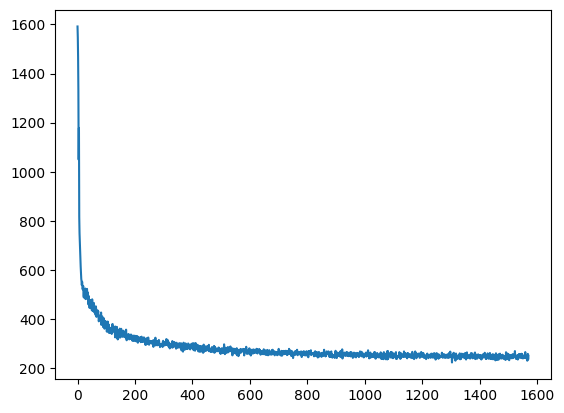

In [6]:
import matplotlib.pyplot as plt 
plt.plot(training_losses)

In [7]:
def sample(num_samples, device):
    # Sample from a standard normal distribution
    z = torch.randn(num_samples, model.encoder.mean.out_features).to(device)
    # Generate data by passing z through the decoder
    samples = model.decoder(z)
    return samples

In [8]:
samples = sample(3, device = device)

In [9]:
# Assuming the model is already trained and `device` is set (e.g., 'cuda' or 'cpu')
num_samples = 3  # Number of new samples you want to generate
samples = sample(num_samples, device)

# Convert samples to numpy arrays and visualize or save them
samples = samples.detach().cpu().numpy()

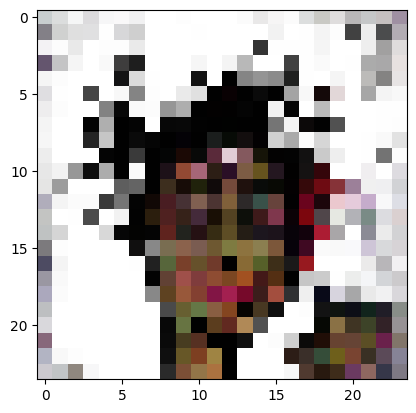

In [12]:
# Example: Display the first sample
plt.imshow(samples[2].transpose(1, 2, 0).astype(float))  
plt.show()